In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from mrmr import mrmr_classif

from src.machinelearning import (
    ANNClassifier,
    evaluate_ann,
    evaluate_sklearn,
    get_predictions,
    train_ann,
    train_decisiontree,
    train_skoperules,
    train_xgboost,
)
from src.ml2rules import TreeRuler, ml2tree, sample_from_df
from src.utils import get_cc_mat, get_dataset, non_stratify_split, stratify_split

In [3]:
def plot_cc_ranges(df: pd.DataFrame) -> None:
    # Change plot style
    plt.style.use("ggplot")
    # Calculate the 1st and 3rd quartiles of df values
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    # Plot the mean of df values
    plt.figure(figsize=(10, 3))
    plt.barh(df.columns[::-1], df.mean()[::-1])
    plt.axvline(x=0, color="black", linestyle="-")
    plt.plot(q1, df.columns, "|", color="black", label="Q1", alpha=1)
    plt.plot(q3, df.columns, "|", color="black", label="Q3", alpha=1)
    for i, enzyme in enumerate(df.columns):
        plt.plot([q1[i], q3[i]], [enzyme, enzyme], color="black")
    plt.title("CC_XTR")
    plt.grid()
    plt.show()
    
def get_value_counts(df: pd.DataFrame) -> None:
    display(
        pd.DataFrame(
        data=[df['label'].value_counts(normalize=True).round(4), df['label'].value_counts()],
        index=["percentage", "absolute"]    
    ).T
    )


### Data loading

***Dataset shape: (200000, 259)

Enzyme: XTR
Common enzymes: ['HXK', 'PGI', 'TPI', 'ZWF', 'ATPM', 'ADK', 'NDR', 'PDA', 'XTR', 'XRI', 'XDH', 'XK']
Number of all enzymes: 86


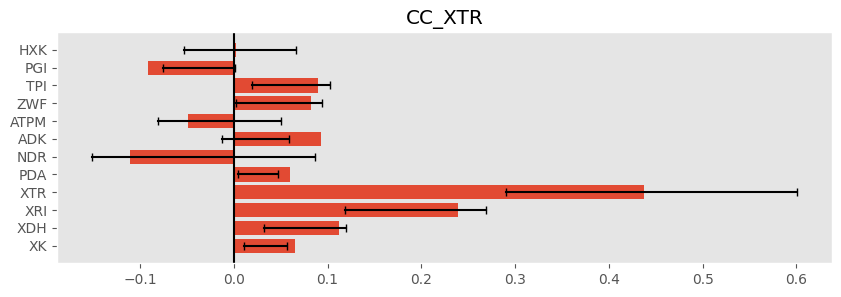

In [4]:
df = get_dataset(
    labels_file="../data/class_vector_train_ref.mat",
    params_file="../data/training_set_ref.mat",
    names_file="../data/paremeterNames.mat",
)

print(f"***Dataset shape: {df.shape}\n")

# Load FCC data
enzyme, commonEnz, allEnzymes, \
    commonConCoeff, allConCoeff = get_cc_mat("../data/ccXTR_ref.mat")

plot_cc_ranges(commonConCoeff)

In [5]:
# Create dataset for HXK enzyme; label 1 if CC < 0, 0 otherwise
idx_HXK = commonConCoeff[commonConCoeff["HXK"] < 0].index

df_HXK = df.drop("label", axis=1)
df_HXK["label"] = [1 if i in idx_HXK else 0 for i in df_HXK.index]
df_HXK["label"].value_counts(normalize=True).round(4)
df = df_HXK.copy()

# Create a dataframe with value_counts both percentage and absolute
display(
    pd.DataFrame(
    data=[df['label'].value_counts(normalize=True).round(4), df['label'].value_counts()],
    index=["percentage", "absolute"]    
).T
)

del df_HXK

,percentage,absolute
0,0.5287,105746.0
1,0.4713,94254.0


### Train - Test data split

In [6]:
# Split data
# X_train, X_test, y_train, y_test = non_stratify_split(
#     data=df, train_size=100000, target="label", zero_class_pct=0.60
# )

X_train, X_test, y_train, y_test = stratify_split(data=df, train_size=10000, target="label")

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print('Training set value counts:')
get_value_counts(train_df)

print('Test set value counts:')
get_value_counts(test_df)

Traininig set shape: (10000, 258)
Test set shape: (190000, 258)
Training set value counts:


,percentage,absolute
0,0.5287,5287.0
1,0.4713,4713.0


Test set value counts:


,percentage,absolute
0,0.5287,100459.0
1,0.4713,89541.0


### Feature Selection

In [7]:
K = int(df.drop("label", axis=1).shape[1] / 25)
print(f"***Number of features to select: {K}")
selected_features = mrmr_classif(X=df.drop("label", axis=1), y=df["label"], K=K)

# keep only selected features
X_train = X_train[selected_features]
X_test = X_test[selected_features]
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(f'Training set shape: {train_df.shape}')
print(f'Test set shape: {test_df.shape}')

***Number of features to select: 10


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]

Training set shape: (10000, 11)
Test set shape: (190000, 11)


### Machine Learning

##### Decision Tree - iSHRUNCK

In [25]:
cart_model = train_decisiontree(X_train, y_train, scoring='accuracy', n_trials=100)

[I 2024-09-30 18:26:46,163] A new study created in memory with name: no-name-3df9d388-b407-4f06-8cf0-e618b8784006
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.572) total time=   0.0s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished
[I 2024-09-30 18:26:48,692] Trial 0 finished with value: 0.571899991438856 and parameters: {'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.571899991438856.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.571) total time=   0.0s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.572) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:26:49,357] Trial 1 finished with value: 0.5734988015898171 and parameters: {'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 1 with value: 0.5734988015898171.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.568) total time=   0.0s
[CV] END ................................ score: (test=0.567) total time=   0.0s
[CV] END ................................ score: (test=0.585) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:26:50,058] Trial 2 finished with value: 0.598299452020787 and parameters: {'max_depth': 3, 'min_samples_split': 21, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 2 with value: 0.598299452020787.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.594) total time=   0.0s
[CV] END ................................ score: (test=0.597) total time=   0.0s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.604) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:26:50,761] Trial 3 finished with value: 0.5557003210818983 and parameters: {'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.598299452020787.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.561) total time=   0.0s
[CV] END ................................ score: (test=0.554) total time=   0.0s
[CV] END ................................ score: (test=0.552) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:26:51,443] Trial 4 finished with value: 0.5664007012578883 and parameters: {'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 2 with value: 0.598299452020787.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.559) total time=   0.0s
[CV] END ................................ score: (test=0.579) total time=   0.0s
[CV] END ................................ score: (test=0.561) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:26:52,187] Trial 5 finished with value: 0.5874995717928121 and parameters: {'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 2 with value: 0.598299452020787.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.592) total time=   0.1s
[CV] END ................................ score: (test=0.590) total time=   0.1s
[CV] END ................................ score: (test=0.581) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:26:52,870] Trial 6 finished with value: 0.5748999914988498 and parameters: {'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 22, 'max_features': 'log2'}. Best is trial 2 with value: 0.598299452020787.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.573) total time=   0.0s
[CV] END ................................ score: (test=0.577) total time=   0.0s
[CV] END ................................ score: (test=0.575) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:26:53,603] Trial 7 finished with value: 0.5726999214618522 and parameters: {'max_depth': 21, 'min_samples_split': 13, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 2 with value: 0.598299452020787.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.573) total time=   0.1s
[CV] END ................................ score: (test=0.581) total time=   0.1s
[CV] END ................................ score: (test=0.564) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:26:54,303] Trial 8 finished with value: 0.5972998319628003 and parameters: {'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 22, 'max_features': None}. Best is trial 2 with value: 0.598299452020787.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.592) total time=   0.0s
[CV] END ................................ score: (test=0.601) total time=   0.0s
[CV] END ................................ score: (test=0.599) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:26:54,986] Trial 9 finished with value: 0.5972998319628003 and parameters: {'max_depth': 5, 'min_samples_split': 24, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 2 with value: 0.598299452020787.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.601) total time=   0.0s
[CV] END ................................ score: (test=0.592) total time=   0.0s
[CV] END ................................ score: (test=0.599) total time=   0.0s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.580) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08397674560546875s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:26:55,703] Trial 10 finished with value: 0.5802000415998408 and parameters: {'max_depth': 10, 'min_samples_split': 23, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 2 with value: 0.598299452020787.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.589) total time=   0.1s
[CV] END ................................ score: (test=0.572) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:26:56,419] Trial 11 finished with value: 0.5845998217098255 and parameters: {'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 2 with value: 0.598299452020787.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.586) total time=   0.0s
[CV] END ................................ score: (test=0.578) total time=   0.0s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.590) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:26:57,154] Trial 12 finished with value: 0.5845998217098255 and parameters: {'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 2 with value: 0.598299452020787.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.590) total time=   0.0s
[CV] END ................................ score: (test=0.578) total time=   0.0s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.586) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:26:57,921] Trial 13 finished with value: 0.578799421633825 and parameters: {'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 2 with value: 0.598299452020787.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.585) total time=   0.1s
[CV] END ................................ score: (test=0.582) total time=   0.1s
[CV] END ................................ score: (test=0.570) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:26:58,668] Trial 14 finished with value: 0.6005997420377911 and parameters: {'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 14 with value: 0.6005997420377911.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.1s
[CV] END ................................ score: (test=0.595) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:26:59,375] Trial 15 finished with value: 0.5710007713428812 and parameters: {'max_depth': 25, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.6005997420377911.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.563) total time=   0.0s
[CV] END ................................ score: (test=0.574) total time=   0.0s
[CV] END ................................ score: (test=0.576) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:27:00,093] Trial 16 finished with value: 0.6022998220637902 and parameters: {'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 16 with value: 0.6022998220637902.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.604) total time=   0.0s
[CV] END ................................ score: (test=0.593) total time=   0.0s
[CV] END ................................ score: (test=0.609) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:27:00,800] Trial 17 finished with value: 0.5908996418538074 and parameters: {'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 16 with value: 0.6022998220637902.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.594) total time=   0.1s
[CV] END ................................ score: (test=0.590) total time=   0.1s
[CV] END ................................ score: (test=0.588) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:27:01,520] Trial 18 finished with value: 0.5929997618838069 and parameters: {'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.6022998220637902.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.585) total time=   0.0s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.595) total time=   0.0s
[CV] END ................................ score: (test=0.599) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:27:02,217] Trial 19 finished with value: 0.5817988817478029 and parameters: {'max_depth': 10, 'min_samples_split': 25, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 16 with value: 0.6022998220637902.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.575) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.593) total time=   0.0s
[CV] END ................................ score: (test=0.577) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished
[I 2024-09-30 18:27:03,035] Trial 20 finished with value: 0.5656005312588847 and parameters: {'max_depth': 12, 'min_samples_split': 22, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 16 with value: 0.6022998220637902.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.562) total time=   0.1s
[CV] END ................................ score: (test=0.574) total time=   0.1s
[CV] END ................................ score: (test=0.560) total time=   0.1s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.597) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05267214775085449s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 18:27:03,751] Trial 21 finished with value: 0.598299452020787 and parameters: {'max_depth': 3, 'min_samples_split': 21, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 16 with value: 0.6022998220637902.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06862711906433105s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:03,860] Trial 22 finished with value: 0.6004994620637828 and parameters: {'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 16 with value: 0.6022998220637902.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.604) total time=   0.0s
[CV] END ................................ score: (test=0.594) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.606) total time=   0.1s
[CV] END ................................ score: (test=0.596) total time=   0.1s
[CV] END ................................ score: (test=0.600) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .................

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06293416023254395s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:03,970] Trial 23 finished with value: 0.6043998820997877 and parameters: {'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 23 with value: 0.6043998820997877.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08759474754333496s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:04,098] Trial 24 finished with value: 0.5613994812798616 and parameters: {'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 23 with value: 0.6043998820997877.


[CV] END ................................ score: (test=0.606) total time=   0.1s
[CV] END ................................ score: (test=0.595) total time=   0.1s
[CV] END ................................ score: (test=0.613) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.567) total time=   0.1s
[CV] END ................................ score: (test=0.569) total time=   0.1s
[CV] END ................................ score: (test=0.549) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06361937522888184s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:04,205] Trial 25 finished with value: 0.5997001319808045 and parameters: {'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 23 with value: 0.6043998820997877.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07745599746704102s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:04,332] Trial 26 finished with value: 0.5873999817498247 and parameters: {'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 23 with value: 0.6043998820997877.


[CV] END ................................ score: (test=0.598) total time=   0.0s
[CV] END ................................ score: (test=0.602) total time=   0.0s
[CV] END ................................ score: (test=0.599) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.588) total time=   0.1s
[CV] END ................................ score: (test=0.586) total time=   0.1s
[CV] END ................................ score: (test=0.589) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04964756965637207s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:04,421] Trial 27 finished with value: 0.6087993022457614 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 27 with value: 0.6087993022457614.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.027987241744995117s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[I 2024-09-30 18:27:04,490] Trial 28 finished with value: 0.5896991918747964 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 27 with value: 0.6087993022457614.
[Parallel(n_jobs=-1)]: Using backend LokyBackend 

[CV] END ................................ score: (test=0.616) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] END ................................ score: (test=0.608) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.598) total time=   0.0s
[CV] END ................................ score: (test=0.569) total time=   0.0s
[CV] END ................................ score: (test=0.602) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.03729534149169922s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[I 2024-09-30 18:27:04,652] Trial 30 finished with value: 0.5796999016038377 and parameters: {'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.6087993022457614.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.062455177307128906s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:04,771] Trial 31 finished with value: 0.6008997720407914 and parameters: {'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 27 with value: 0.6087993022457614.
[Parallel(n_jobs=-1)]: Using backend LokyBacke

[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.581) total time=   0.0s
[CV] END ................................ score: (test=0.589) total time=   0.0s
[CV] END ................................ score: (test=0.569) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.603) total time=   0.1s
[CV] END ................................ score: (test=0.596) total time=   0.1s
[CV] END ................................ score: (test=0.603) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Batch computation too fast (0.052994728088378906s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:04,870] Trial 32 finished with value: 0.6094992522647585 and parameters: {'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05402684211730957s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:04,959] Trial 33 finished with value: 0.6094992522647585 and parameters: {'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.617) total time=   0.0s
[CV] END ................................ score: (test=0.608) total time=   0.0s
[CV] END ................................ score: (test=0.604) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.617) total time=   0.0s
[CV] END ................................ score: (test=0.608) total time=   0.0s
[CV] END ................................ score: (test=0.604) total time=   0.0s
[CV] START .....................................................................
[CV] START .................

[Parallel(n_jobs=-1)]: Batch computation too fast (0.05035686492919922s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:05,049] Trial 34 finished with value: 0.6093992422637585 and parameters: {'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04434537887573242s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:05,138] Trial 35 finished with value: 0.598299452020787 and parameters: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (

[CV] END ................................ score: (test=0.617) total time=   0.0s
[CV] END ................................ score: (test=0.608) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.604) total time=   0.0s
[CV] END ................................ score: (test=0.594) total time=   0.0s
[CV] END ................................ score: (test=0.597) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.03638195991516113s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[I 2024-09-30 18:27:05,286] Trial 37 finished with value: 0.5845998217098255 and parameters: {'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04309487342834473s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:05,378] Trial 38 finished with value: 0.6087993022457614 and parameters: {'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend w

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.586) total time=   0.0s
[CV] END ................................ score: (test=0.590) total time=   0.0s
[CV] END ................................ score: (test=0.578) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.616) total time=   0.0s
[CV] END ................................ score: (test=0.608) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] START .................

[Parallel(n_jobs=-1)]: Batch computation too fast (0.04292488098144531s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:05,455] Trial 39 finished with value: 0.5685997513968554 and parameters: {'max_depth': 19, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.03838038444519043s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[I 2024-09-30 18:27:05,533] Trial 40 finished with value: 0.5838997217058238 and parameters: {'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too f

[CV] END ................................ score: (test=0.571) total time=   0.0s
[CV] END ................................ score: (test=0.575) total time=   0.0s
[CV] END ................................ score: (test=0.560) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.587) total time=   0.0s
[CV] END ................................ score: (test=0.584) total time=   0.0s
[CV] END ................................ score: (test=0.581) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05165982246398926s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:05,713] Trial 42 finished with value: 0.6094992522647585 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.038838863372802734s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:05,793] Trial 43 finished with value: 0.598299452020787 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.617) total time=   0.0s
[CV] END ................................ score: (test=0.608) total time=   0.0s
[CV] END ................................ score: (test=0.604) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.604) total time=   0.0s
[CV] END ................................ score: (test=0.594) total time=   0.0s
[CV] END ................................ score: (test=0.597) total time=   0.0s
[CV] START .................

[Parallel(n_jobs=-1)]: Batch computation too fast (0.03310561180114746s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[I 2024-09-30 18:27:05,863] Trial 44 finished with value: 0.5845998217098255 and parameters: {'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05397605895996094s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:05,963] Trial 45 finished with value: 0.6003001919868052 and parameters: {'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.598) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] END ................................ score: (test=0.600) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.606) total time=   0.1s
[CV] END ................................ score: (test=0.596) total time=   0.1s
[CV] END ................................ score: (test=0.597) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04286694526672363s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:06,154] Trial 47 finished with value: 0.598299452020787 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0559844970703125s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:06,254] Trial 48 finished with value: 0.6003001919868052 and parameters: {'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.604) total time=   0.0s
[CV] END ................................ score: (test=0.594) total time=   0.0s
[CV] END ................................ score: (test=0.597) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.598) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] END ................................ score: (test=0.600) total time=   0.0s
[CV] START .................

[Parallel(n_jobs=-1)]: Batch computation too fast (0.08834576606750488s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:06,384] Trial 49 finished with value: 0.5593989812898507 and parameters: {'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07132649421691895s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:06,505] Trial 50 finished with value: 0.5857997017458194 and parameters: {'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.


[CV] END ................................ score: (test=0.570) total time=   0.1s
[CV] END ................................ score: (test=0.546) total time=   0.1s
[CV] END ................................ score: (test=0.562) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.589) total time=   0.1s
[CV] END ................................ score: (test=0.584) total time=   0.1s
[CV] END ................................ score: (test=0.584) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05018305778503418s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:06,596] Trial 51 finished with value: 0.6087993022457614 and parameters: {'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04705452919006348s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:06,687] Trial 52 finished with value: 0.608599372234764 and parameters: {'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

[CV] END ................................ score: (test=0.616) total time=   0.0s
[CV] END ................................ score: (test=0.608) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.615) total time=   0.0s
[CV] END ................................ score: (test=0.608) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.044019222259521484s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:06,857] Trial 54 finished with value: 0.598299452020787 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08502674102783203s.) Setting batch_size=2.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.604) total time=   0.0s
[CV] END ................................ score: (test=0.594) total time=   0.0s
[CV] END ................................ score: (test=0.597) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.569) total time=   0.1s
[CV] END ................................ score: (test=0.557) total time=   0.1s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:07,032] Trial 55 finished with value: 0.5654996513448586 and parameters: {'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.03003215789794922s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[I 2024-09-30 18:27:07,101] Trial 56 finished with value: 0.5836002616458407 and parameters: {'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06906294822692871s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | ela

[CV] END ................................ score: (test=0.570) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.581) total time=   0.0s
[CV] END ................................ score: (test=0.605) total time=   0.0s
[CV] END ................................ score: (test=0.564) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.605) total time=   0.1s
[CV] END ................................ score: (test=0.597) total time=   0.1s
[CV] END ...................

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08486604690551758s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:07,342] Trial 58 finished with value: 0.5634993913308548 and parameters: {'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.03740358352661133s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[I 2024-09-30 18:27:07,420] Trial 59 finished with value: 0.5794005315348572 and parameters: {'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 32 with value: 0.6094992522647585.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.570) total time=   0.1s
[CV] END ................................ score: (test=0.558) total time=   0.1s
[CV] END ................................ score: (test=0.563) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.574) total time=   0.0s
[CV] END ................................ score: (test=0.576) total time=   0.0s
[CV] END ................................ score: (test=0.588) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.061710357666015625s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:07,520] Trial 60 finished with value: 0.6038998320947871 and parameters: {'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.050994157791137695s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:07,611] Trial 61 finished with value: 0.6091992222617583 and parameters: {'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend 

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.613) total time=   0.0s
[CV] END ................................ score: (test=0.606) total time=   0.1s
[CV] END ................................ score: (test=0.593) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.617) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] END ................................ score: (test=0.608) total time=   0.0s
[CV] START .................

[Parallel(n_jobs=-1)]: Batch computation too fast (0.05052995681762695s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:07,701] Trial 62 finished with value: 0.6091992222617583 and parameters: {'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04116177558898926s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:07,783] Trial 63 finished with value: 0.598299452020787 and parameters: {'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (

[CV] END ................................ score: (test=0.617) total time=   0.0s
[CV] END ................................ score: (test=0.608) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.604) total time=   0.0s
[CV] END ................................ score: (test=0.594) total time=   0.0s
[CV] END ................................ score: (test=0.597) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.03512263298034668s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[I 2024-09-30 18:27:07,956] Trial 65 finished with value: 0.5845998217098255 and parameters: {'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05409741401672363s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:08,077] Trial 66 finished with value: 0.6003001919868052 and parameters: {'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend w

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.586) total time=   0.0s
[CV] END ................................ score: (test=0.590) total time=   0.0s
[CV] END ................................ score: (test=0.578) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.598) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] END ................................ score: (test=0.600) total time=   0.1s
[CV] START .................

[Parallel(n_jobs=-1)]: Batch computation too fast (0.07518577575683594s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:08,186] Trial 67 finished with value: 0.6047999221037881 and parameters: {'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05116868019104004s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:08,277] Trial 68 finished with value: 0.6082993422317636 and parameters: {'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 24, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast 

[CV] END ................................ score: (test=0.613) total time=   0.1s
[CV] END ................................ score: (test=0.606) total time=   0.1s
[CV] END ................................ score: (test=0.596) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.615) total time=   0.0s
[CV] END ................................ score: (test=0.607) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.02531266212463379s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[I 2024-09-30 18:27:08,442] Trial 70 finished with value: 0.5702994714588435 and parameters: {'max_depth': 2, 'min_samples_split': 12, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05054354667663574s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:08,533] Trial 71 finished with value: 0.6087993022457614 and parameters: {'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.576) total time=   0.0s
[CV] END ................................ score: (test=0.557) total time=   0.0s
[CV] END ................................ score: (test=0.579) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.616) total time=   0.0s
[CV] END ................................ score: (test=0.608) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] START .................

[Parallel(n_jobs=-1)]: Batch computation too fast (0.04157662391662598s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:08,614] Trial 72 finished with value: 0.598299452020787 and parameters: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.049840450286865234s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:08,724] Trial 73 finished with value: 0.6087993022457614 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.616) total time=   0.0s
[CV] END ................................ score: (test=0.608) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.598) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] END ................................ score: (test=0.599) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06367802619934082s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:08,932] Trial 75 finished with value: 0.6043998820997877 and parameters: {'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04330563545227051s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:09,024] Trial 76 finished with value: 0.598299452020787 and parameters: {'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.606) total time=   0.1s
[CV] END ................................ score: (test=0.613) total time=   0.1s
[CV] END ................................ score: (test=0.595) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.604) total time=   0.0s
[CV] END ................................ score: (test=0.594) total time=   0.0s
[CV] END ................................ score: (test=0.597) total time=   0.0s
[CV] START .................

[Parallel(n_jobs=-1)]: Batch computation too fast (0.06064963340759277s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:09,129] Trial 77 finished with value: 0.5974001119368086 and parameters: {'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0617983341217041s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:09,241] Trial 78 finished with value: 0.6028997320847861 and parameters: {'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.596) total time=   0.0s
[CV] END ................................ score: (test=0.602) total time=   0.0s
[CV] END ................................ score: (test=0.594) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.606) total time=   0.1s
[CV] END ................................ score: (test=0.594) total time=   0.1s
[CV] END ................................ score: (test=0.609) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05160021781921387s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:09,343] Trial 79 finished with value: 0.6087993022457614 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.03670191764831543s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[I 2024-09-30 18:27:09,423] Trial 80 finished with value: 0.5909999218278157 and parameters: {'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend 

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.616) total time=   0.0s
[CV] END ................................ score: (test=0.608) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.592) total time=   0.0s
[CV] END ................................ score: (test=0.589) total time=   0.0s
[CV] END ................................ score: (test=0.593) total time=   0.0s
[CV] START .................

[Parallel(n_jobs=-1)]: Batch computation too fast (0.04646182060241699s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:09,513] Trial 81 finished with value: 0.6091992222617583 and parameters: {'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04302811622619629s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:09,593] Trial 82 finished with value: 0.598299452020787 and parameters: {'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (

[CV] END ................................ score: (test=0.617) total time=   0.0s
[CV] END ................................ score: (test=0.608) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.604) total time=   0.0s
[CV] END ................................ score: (test=0.597) total time=   0.0s
[CV] END ................................ score: (test=0.594) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.03493952751159668s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[I 2024-09-30 18:27:09,776] Trial 84 finished with value: 0.5845998217098255 and parameters: {'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.055970191955566406s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:09,885] Trial 85 finished with value: 0.598099941967802 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.586) total time=   0.0s
[CV] END ................................ score: (test=0.590) total time=   0.0s
[CV] END ................................ score: (test=0.578) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.599) total time=   0.0s
[CV] END ................................ score: (test=0.602) total time=   0.1s
[CV] END ................................ score: (test=0.594) total time=   0.1s
[CV] START .................

[Parallel(n_jobs=-1)]: Batch computation too fast (0.046437978744506836s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:09,965] Trial 86 finished with value: 0.598299452020787 and parameters: {'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05005168914794922s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:10,071] Trial 87 finished with value: 0.6093992422637585 and parameters: {'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] END ................................ score: (test=0.604) total time=   0.0s
[CV] END ................................ score: (test=0.594) total time=   0.0s
[CV] END ................................ score: (test=0.597) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.617) total time=   0.0s
[CV] END ................................ score: (test=0.608) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Batch computation too fast (0.043108463287353516s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:10,166] Trial 88 finished with value: 0.5763995715708344 and parameters: {'max_depth': 13, 'min_samples_split': 19, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08213090896606445s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:10,289] Trial 89 finished with value: 0.5987994420317856 and parameters: {'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fa

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.604) total time=   0.1s
[CV] END ................................ score: (test=0.596) total time=   0.1s
[CV] END ................................ score: (test=0.596) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.603) total time=   0.1s
[CV] END ................................ score: (test=0.600) total time=   0.1s
[CV] END ................................ score: (test=0.598) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05797886848449707s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:10,501] Trial 91 finished with value: 0.6092992022657574 and parameters: {'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06011366844177246s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:10,605] Trial 92 finished with value: 0.6092992022657574 and parameters: {'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.608) total time=   0.0s
[CV] END ................................ score: (test=0.617) total time=   0.0s
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.608) total time=   0.0s
[CV] END ................................ score: (test=0.617) total time=   0.1s
[CV] END ................................ score: (test=0.603) total time=   0.0s
[CV] START .................

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06378722190856934s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:10,727] Trial 93 finished with value: 0.6017995620797832 and parameters: {'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04380917549133301s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:10,821] Trial 94 finished with value: 0.598299452020787 and parameters: {'max_depth': 3, 'min_samples_split': 21, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.606) total time=   0.1s
[CV] END ................................ score: (test=0.605) total time=   0.1s
[CV] END ................................ score: (test=0.594) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.597) total time=   0.0s
[CV] END ................................ score: (test=0.594) total time=   0.0s
[CV] END ................................ score: (test=0.604) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06081247329711914s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:10,926] Trial 95 finished with value: 0.6094992522647585 and parameters: {'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.038709402084350586s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[I 2024-09-30 18:27:11,008] Trial 96 finished with value: 0.5845998217098255 and parameters: {'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend w

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.617) total time=   0.0s
[CV] END ................................ score: (test=0.608) total time=   0.0s
[CV] END ................................ score: (test=0.604) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.590) total time=   0.0s
[CV] END ................................ score: (test=0.586) total time=   0.0s
[CV] END ................................ score: (test=0.578) total time=   0.0s
[CV] START .................

[Parallel(n_jobs=-1)]: Batch computation too fast (0.04509735107421875s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:11,100] Trial 97 finished with value: 0.598299452020787 and parameters: {'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08342862129211426s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:11,241] Trial 98 finished with value: 0.5906990519087901 and parameters: {'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.


[CV] END ................................ score: (test=0.594) total time=   0.0s
[CV] END ................................ score: (test=0.597) total time=   0.0s
[CV] END ................................ score: (test=0.604) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.592) total time=   0.1s
[CV] END ................................ score: (test=0.600) total time=   0.1s
[CV] END ................................ score: (test=0.580) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09012532234191895s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:27:11,377] Trial 99 finished with value: 0.5640990013818418 and parameters: {'max_depth': 17, 'min_samples_split': 19, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 32 with value: 0.6094992522647585.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.574) total time=   0.1s
[CV] END ................................ score: (test=0.555) total time=   0.1s
[CV] END ................................ score: (test=0.563) total time=   0.1s


In [26]:
cart_model

DecisionTreeClassifier(max_depth=4, min_samples_leaf=11, min_samples_split=16)

In [27]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(cart_model, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(cart_model, X_test, y_test)

*** Evaluation on training set:
Accuracy: 0.6312
Precision: 0.6321
Recall: 0.5205
F1 score: 0.5709
ROC AUC score: 0.6252
MCC: 0.2565

*** Evaluation on test set:
Accuracy: 0.6075
Precision: 0.6011
Recall: 0.4972
F1 score: 0.5442
ROC AUC score: 0.6015
MCC: 0.2078


In [28]:
ruler = TreeRuler(df=train_df, tree_clf=cart_model, target="label")
ruler.get_rules()
print(f'Number of rules: {len(ruler.rules)}')
ruler.rules

Number of rules: 16


['if (XRI@nadh_c > 0.529) and (XRI@nad_c <= 0.888) and (ASN@pi_m <= 0.642) and (XRI@nadh_c <= 0.845) then class: 0 (proba: 65.53%) | based on 1,909 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m <= 0.582) and (XRI@nad_c <= 0.565) and (PGK@dpg_c <= 0.933) then class: 0 (proba: 58.36%) | based on 1,753 samples',
 'if (XRI@nadh_c > 0.529) and (XRI@nad_c <= 0.888) and (ASN@pi_m > 0.642) and (GND1@6pgl_c <= 0.866) then class: 0 (proba: 57.49%) | based on 1,075 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m <= 0.582) and (XRI@nad_c > 0.565) and (TPI@t3p_c > 0.315) then class: 1 (proba: 59.81%) | based on 1,035 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m > 0.582) and (TPI@t3p_c <= 0.479) and (ASN@pi_m <= 0.925) then class: 1 (proba: 55.4%) | based on 843 samples',
 'if (XRI@nadh_c > 0.529) and (XRI@nad_c <= 0.888) and (ASN@pi_m <= 0.642) and (XRI@nadh_c > 0.845) then class: 0 (proba: 78.74%) | based on 823 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m > 0.582) and (TPI@t3p

In [32]:
rule = ruler.get_rule_constraints(6)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

['XRI@nadh_c<=0.529', 'ASN@pi_m>0.582', 'TPI@t3p_c>0.479', 'XDH@xlt_c<=0.728']
Number of parameter sets following the rule: 15070


,percentage,absolute
1,0.6934,10450.0
0,0.3066,4620.0


In [36]:
sampled_df['GND1@6pgl_c'].describe()

count    15070.000000
mean         0.511541
std          0.291137
min          0.001053
25%          0.258070
50%          0.518311
75%          0.764239
max          0.998977
Name: GND1@6pgl_c, dtype: float64

In [39]:
sampled_df[sampled_df['GND1@6pgl_c'] > 0.60]['label'].value_counts(normalize=True).round(4)

1    0.7136
0    0.2864
Name: label, dtype: float64

##### Skope - Rules

In [33]:
skope_rules_clf = train_skoperules(X_train, y_train, scoring='precision', n_iter=100)

In [ ]:
skope_rules_clf

In [ ]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(skope_rules_clf, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(skope_rules_clf, X_test, y_test)

In [ ]:
# Print skope-rules rules
print(f'*** Number of rules {len(skope_rules_clf.rules_)}')

# Get rules
for i in skope_rules_clf.rules_:
    print(i)

In [ ]:
_ = test_df[test_df['XRI@nadh_c'] <= 0.5797 ]
_ = _[_['ASN@pi_m'] > 0.5426 ]
_ = _[_['XDH@xlt_c'] <= 0.8568]

get_value_counts(_)

##### XGBoost

In [11]:
xgb_model = train_xgboost(X_train, y_train, scoring='accuracy', n_trials=100)

[CV] END ................................ score: (test=0.637) total time=   0.3s
[CV] END ................................ score: (test=0.627) total time=   0.3s
[CV] END ................................ score: (test=0.629) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 18:19:45,109] Trial 89 finished with value: 0.6298993126667195 and parameters: {'learning_rate': 0.15674229445386875, 'n_estimators': 70, 'max_depth': 2, 'subsample': 0.7543127639145673, 'tree_method': 'exact', 'reg_alpha': 0.32990722826618457, 'reg_lambda': 0.5677683725411579}. Best is trial 66 with value: 0.6350997427277222.


[CV] END ................................ score: (test=0.637) total time=   0.2s
[CV] END ................................ score: (test=0.626) total time=   0.3s
[CV] END ................................ score: (test=0.627) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 18:19:45,563] Trial 90 finished with value: 0.6251994125627319 and parameters: {'learning_rate': 0.026733085661353254, 'n_estimators': 72, 'max_depth': 3, 'subsample': 0.9305645012522676, 'tree_method': 'exact', 'reg_alpha': 0.22643677453503044, 'reg_lambda': 0.5400568620208509}. Best is trial 66 with value: 0.6350997427277222.


[CV] END ................................ score: (test=0.631) total time=   0.4s
[CV] END ................................ score: (test=0.625) total time=   0.4s
[CV] END ................................ score: (test=0.620) total time=   0.4s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 18:19:45,845] Trial 91 finished with value: 0.6311995026737226 and parameters: {'learning_rate': 0.18289632657820368, 'n_estimators': 65, 'max_depth': 2, 'subsample': 0.8086003318179439, 'tree_method': 'exact', 'reg_alpha': 0.30535208162387334, 'reg_lambda': 0.6563941745970152}. Best is trial 66 with value: 0.6350997427277222.


[CV] END ................................ score: (test=0.636) total time=   0.2s
[CV] END ................................ score: (test=0.635) total time=   0.2s
[CV] END ................................ score: (test=0.622) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 18:19:46,128] Trial 92 finished with value: 0.6308992026977143 and parameters: {'learning_rate': 0.19446564998193316, 'n_estimators': 61, 'max_depth': 2, 'subsample': 0.8343499919135025, 'tree_method': 'exact', 'reg_alpha': 0.2767598588681661, 'reg_lambda': 0.7226014495982777}. Best is trial 66 with value: 0.6350997427277222.


[CV] END ................................ score: (test=0.631) total time=   0.2s
[CV] END ................................ score: (test=0.639) total time=   0.2s
[CV] END ................................ score: (test=0.623) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 18:19:46,399] Trial 93 finished with value: 0.6323997126767266 and parameters: {'learning_rate': 0.17429428202060823, 'n_estimators': 57, 'max_depth': 2, 'subsample': 0.8175375794343547, 'tree_method': 'exact', 'reg_alpha': 0.3549016680913893, 'reg_lambda': 0.6710327834974834}. Best is trial 66 with value: 0.6350997427277222.


[CV] END ................................ score: (test=0.635) total time=   0.2s
[CV] END ................................ score: (test=0.633) total time=   0.2s
[CV] END ................................ score: (test=0.629) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 18:19:46,705] Trial 94 finished with value: 0.629699412652723 and parameters: {'learning_rate': 0.16379607965441237, 'n_estimators': 66, 'max_depth': 2, 'subsample': 0.8965754009262131, 'tree_method': 'exact', 'reg_alpha': 0.3471116646228195, 'reg_lambda': 0.6445132208475722}. Best is trial 66 with value: 0.6350997427277222.


[CV] END ................................ score: (test=0.636) total time=   0.2s
[CV] END ................................ score: (test=0.625) total time=   0.2s
[CV] END ................................ score: (test=0.629) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 18:19:47,098] Trial 95 finished with value: 0.6270994825937303 and parameters: {'learning_rate': 0.1885644945516228, 'n_estimators': 63, 'max_depth': 3, 'subsample': 0.87135358844937, 'tree_method': 'exact', 'reg_alpha': 0.24848224989156809, 'reg_lambda': 0.7436246905919657}. Best is trial 66 with value: 0.6350997427277222.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.054503440856933594s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 18:19:47,212] Trial 96 finished with value: 0.6306986727466988 and parameters: {'learning_rate': 0.19499243024900453, 'n_estimators': 46, 'max_depth': 2, 'subsample': 0.852447549961073, 'tree_method': 'hist', 'reg_alpha': 0.3760356643794851, 'reg_lambda

[CV] END ................................ score: (test=0.632) total time=   0.3s
[CV] END ................................ score: (test=0.629) total time=   0.3s
[CV] END ................................ score: (test=0.620) total time=   0.3s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.644) total time=   0.0s
[CV] END ................................ score: (test=0.626) total time=   0.0s
[CV] END ................................ score: (test=0.623) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished
[I 2024-09-30 18:19:48,639] Trial 97 finished with value: 0.6048991221857639 and parameters: {'learning_rate': 0.09571482032155336, 'n_estimators': 60, 'max_depth': 11, 'subsample': 0.8841069977346264, 'tree_method': 'exact', 'reg_alpha': 0.39213230178028985, 'reg_lambda': 0.6853237207039016}. Best is trial 66 with value: 0.6350997427277222.


[CV] END ................................ score: (test=0.614) total time=   1.3s
[CV] END ................................ score: (test=0.608) total time=   1.3s
[CV] END ................................ score: (test=0.593) total time=   1.4s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[I 2024-09-30 18:19:49,087] Trial 98 finished with value: 0.6264992726027252 and parameters: {'learning_rate': 0.11182842284090963, 'n_estimators': 52, 'max_depth': 4, 'subsample': 0.8313020590808817, 'tree_method': 'auto', 'reg_alpha': 0.4559681705605744, 'reg_lambda': 0.6293078695094844}. Best is trial 66 with value: 0.6350997427277222.


[CV] END ................................ score: (test=0.634) total time=   0.4s
[CV] END ................................ score: (test=0.626) total time=   0.4s
[CV] END ................................ score: (test=0.620) total time=   0.4s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 18:19:49,412] Trial 99 finished with value: 0.6363997527527198 and parameters: {'learning_rate': 0.18119648643455633, 'n_estimators': 72, 'max_depth': 2, 'subsample': 0.7990532474376462, 'tree_method': 'exact', 'reg_alpha': 0.31697967836332724, 'reg_lambda': 0.7129855290087396}. Best is trial 99 with value: 0.6363997527527198.


[CV] END ................................ score: (test=0.639) total time=   0.2s
[CV] END ................................ score: (test=0.637) total time=   0.2s
[CV] END ................................ score: (test=0.634) total time=   0.3s


In [ ]:
xgb_model

In [ ]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(xgb_model, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(xgb_model, X_test, y_test)

In [ ]:
xgb_preds = xgb_model.predict(X_train)
xgb2tree = ml2tree(X_train, xgb_preds, scoring='accuracy', n_trials=100)

In [ ]:
xgb2tree

In [ ]:
evaluate_sklearn(xgb2tree, X_test, y_test)

In [ ]:
ruler = TreeRuler(df=train_df, tree_clf=xgb2tree, target="label")
ruler.get_rules()
ruler.rules

In [ ]:
rule = ruler.get_rule_constraints(1)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

##### Neural Network

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = ANNClassifier(input_dim=X_train.shape[1], hidden_dim=2048,
                    output_dim=1, hidden_layers=4).to(device)

net = train_ann(net, X_train, y_train, num_epochs=1000, learning_rate=0.001, batch_size=2048)

In [ ]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_ann(net, X_train, y_train)
print()

print('*** Evaluation on test set:')
evaluate_ann(net, X_test, y_test)

In [ ]:
ann_preds = get_predictions(net, X_train)
ann2tree = ml2tree(X_train, ann_preds, n_trials=25
                   )

In [ ]:
ann2tree

In [ ]:
evaluate_sklearn(ann2tree, X_test, y_test)

In [ ]:
ruler = TreeRuler(df=train_df, tree_clf=ann2tree, target="label")
ruler.get_rules()
ruler.rules

In [ ]:
rule = ruler.get_rule_constraints(2)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

### Exlainable Machine Learning

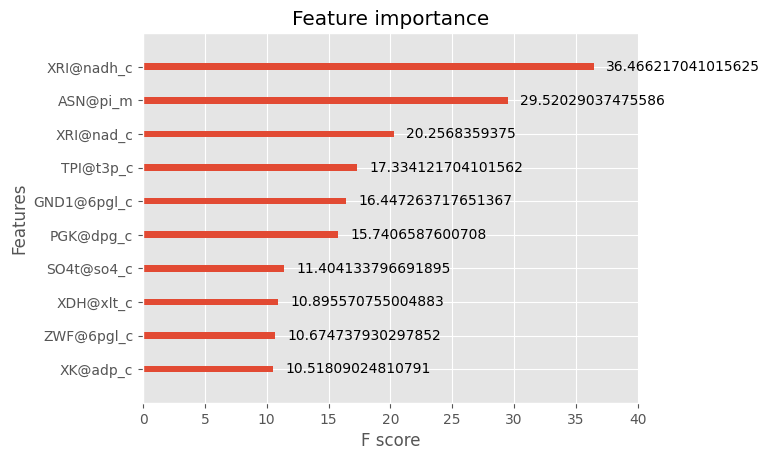

In [12]:
xgb.plot_importance(xgb_model, importance_type='gain')
plt.show()

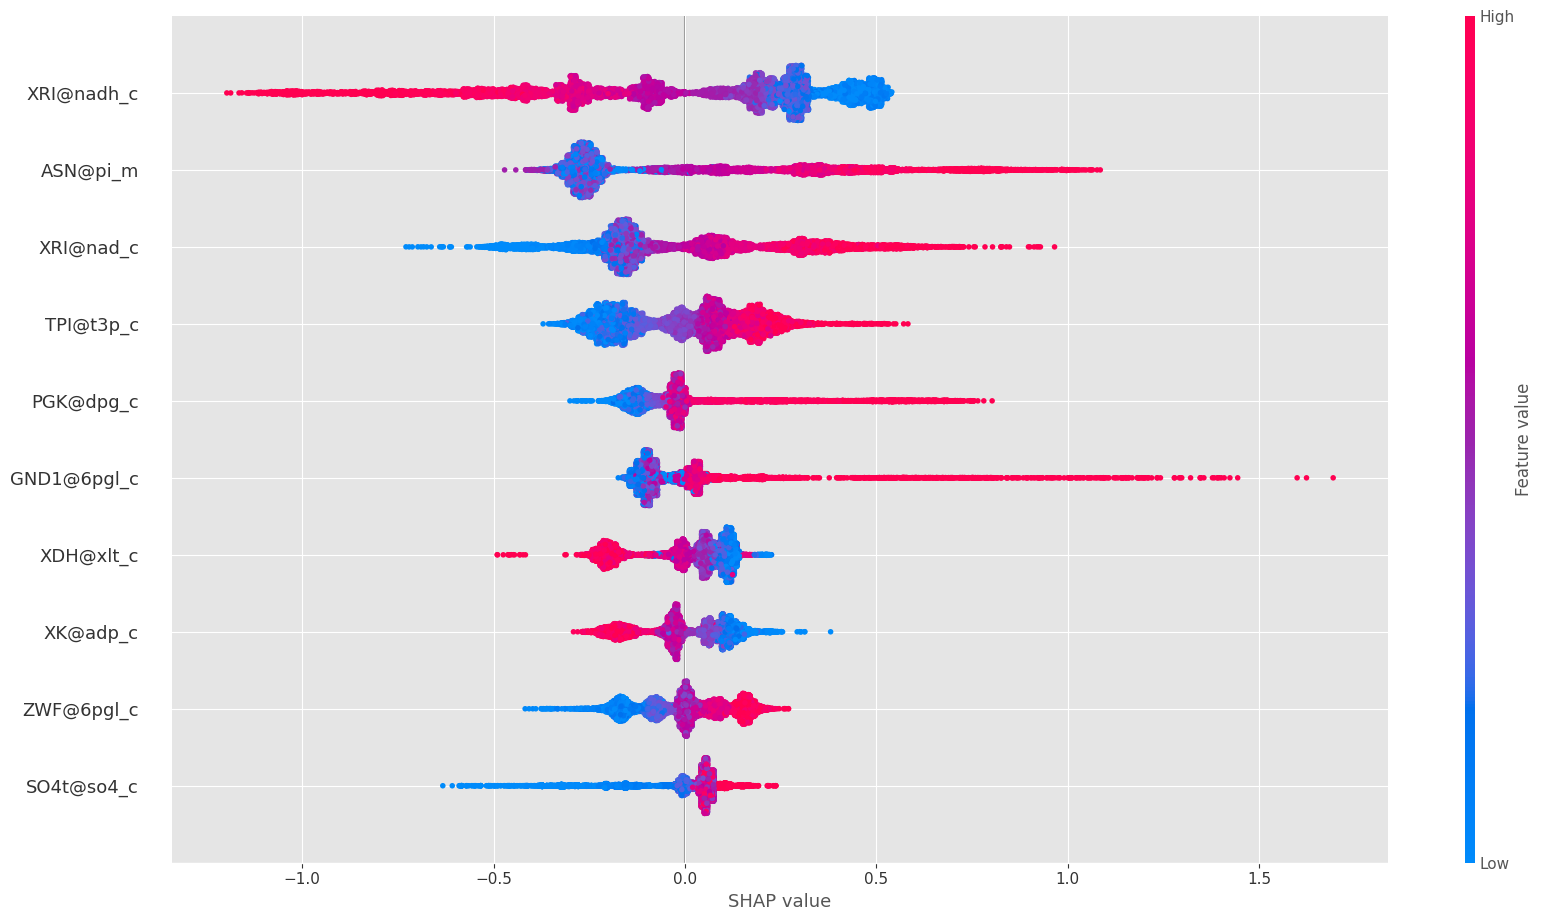

In [20]:
import shap

# Create a TreeExplainer for the xgb_model
explainer = shap.TreeExplainer(xgb_model)
# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train)
# Display the SHAP summary plot

fig = plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="dot", show=False)
plt.gcf().set_size_inches(20,10)
plt.xlabel("SHAP value")
plt.show()

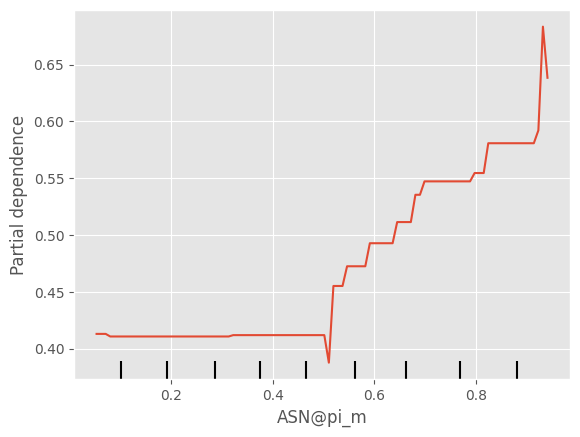

In [24]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(xgb_model, X_train, features=['ASN@pi_m'])
plt.show()